# Classifier model exploration

In [55]:
import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import pickle

## Access processed data

In [56]:
DIR_REPO = Path.cwd().parent.parent
DIR_DATA_PROCESSED = Path(DIR_REPO) / "data" / "processed"
DIR_MODELS = Path(DIR_REPO) / "models"

os.listdir(DIR_DATA_PROCESSED)

['preprocessed_listings.csv']

In [57]:
FILEPATH_PROCESSED = DIR_DATA_PROCESSED / "preprocessed_listings.csv"

In [58]:
df = pd.read_csv(FILEPATH_PROCESSED, index_col=0)
df.head()

,id,neighbourhood,property_type,room_type,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,category,TV,Internet,Air_conditioning,Kitchen,Heating,Wifi,Elevator,Breakfast
1,3831,Brooklyn,Entire guest suite,Entire home/apt,40.68494,-73.95765,3,1.0,1.0,3.0,75,0.0,1,0,1,1,1,1,0,0
3,5136,Brooklyn,Entire rental unit,Entire home/apt,40.66265,-73.99454,4,1.5,2.0,2.0,275,2.0,1,0,1,1,1,1,0,0
4,5178,Manhattan,Private room in rental unit,Private room,40.76457,-73.98317,2,1.0,1.0,1.0,68,0.0,1,0,1,0,1,1,0,0
5,5203,Manhattan,Private room in rental unit,Private room,40.80380,-73.96751,1,1.0,1.0,1.0,75,0.0,0,0,1,0,1,1,1,1
8,6872,Manhattan,Private room in condominium (condo),Private room,40.80107,-73.94255,1,1.0,1.0,1.0,65,0.0,0,0,0,1,1,1,1,0


In [59]:
df = df.dropna(axis=0)

In [60]:
df.columns

Index(['id', 'neighbourhood', 'property_type', 'room_type', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'category', 'TV', 'Internet', 'Air_conditioning', 'Kitchen', 'Heating',
       'Wifi', 'Elevator', 'Breakfast'],
      dtype='object')

## Convert string to categorical variable

In [61]:
# Categorical variable mapping dictionaries
MAP_ROOM_TYPE = {"Shared room": 1, "Private room": 2, "Entire home/apt": 3, "Hotel room": 4}
MAP_NEIGHB = {"Bronx": 1, "Queens": 2, "Staten Island": 3, "Brooklyn": 4, "Manhattan": 5}

In [62]:
# Map categorical features
df["neighbourhood"] = df["neighbourhood"].map(MAP_NEIGHB)
df["room_type"] = df["room_type"].map(MAP_ROOM_TYPE)

## Split data for cross-validation

In [63]:
FEATURE_NAMES = ['neighbourhood', 'room_type', 'accommodates', 'bathrooms', 'bedrooms']

X = df[FEATURE_NAMES]
y = df['category']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

## A simple classifier model

### Train the model

In [65]:
clf = RandomForestClassifier(n_estimators=500, random_state=0, class_weight='balanced', n_jobs=4)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500, n_jobs=4,
                       random_state=0)

### Evaluate the model

In [66]:
y_pred = clf.predict(X_test)

In [67]:
# Compute overall accuracy
accuracy_score(y_test, y_pred)

0.6047339757017176

In [68]:
# Compute overall one-versus-rest area under the ROC

y_proba = clf.predict_proba(X_test)
roc_auc_score(y_test, y_proba, multi_class='ovr')

0.8183801557997225

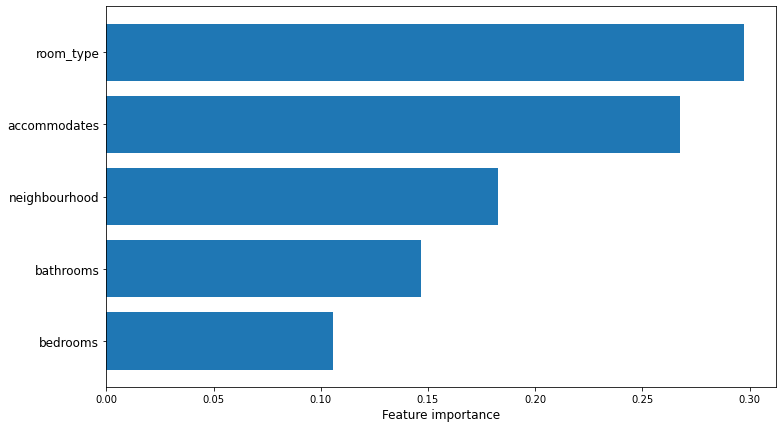

In [69]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns[indices]
importances = importances[indices]

fig, ax = plt.subplots(figsize=(12, 7))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), features, fontsize=12)
ax.invert_yaxis()
ax.set_xlabel("Feature importance", fontsize=12)

plt.show()

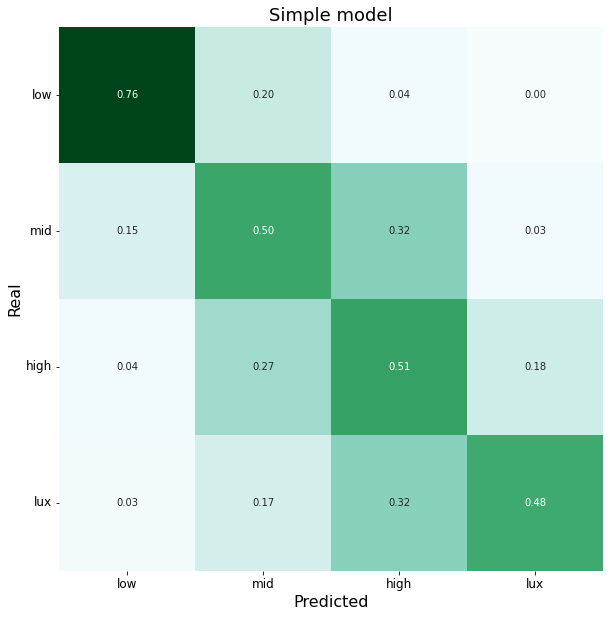

In [70]:
classes = [0, 1, 2, 3]
labels = ['low', 'mid', 'high', 'lux']

c = confusion_matrix(y_test, y_pred)
c = c / c.sum(axis=1).reshape(len(classes), 1)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(c, annot=True, cmap='BuGn', square=True, fmt='.2f', annot_kws={'size': 10}, cbar=False)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Real', fontsize=16)
plt.xticks(ticks=np.arange(.5, len(classes)), labels=labels, rotation=0, fontsize=12)
plt.yticks(ticks=np.arange(.5, len(classes)), labels=labels, rotation=0, fontsize=12)
plt.title("Simple model", fontsize=18)

plt.show()

In [71]:
maps = {'0.0': 'low', '1.0': 'mid', '2.0': 'high', '3.0': 'lux'}

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame.from_dict(report).T[:-3]
df_report.index = [maps[i] for i in df_report.index]
df_report

,precision,recall,f1-score,support
low,0.840909,0.757033,0.796770,1955.0
mid,0.532355,0.495345,0.513183,1611.0
high,0.431138,0.508577,0.466667,991.0
lux,0.303468,0.483871,0.373002,217.0


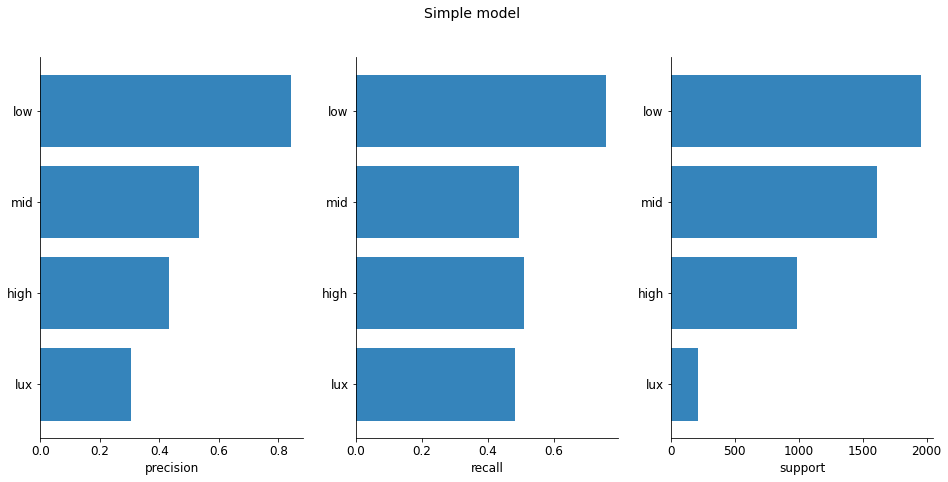

In [72]:
metrics = ['precision', 'recall', 'support']

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 7))

for i, ax in enumerate(axes):

    ax.barh(df_report.index, df_report[metrics[i]], alpha=0.9)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.set_xlabel(metrics[i], fontsize=12)
    ax.invert_yaxis()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.suptitle("Simple model", fontsize=14)
plt.show()

In [73]:
pickle.dump(clf, open(DIR_MODELS / "simple_classifier.pkl", 'wb'))